In [8]:
import pandas as pd
from sklearn.metrics import f1_score

from lbl2vec import Lbl2TransformerVec

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [11]:
def evaluate_lbl2vec_on_dataset(dataset_name: str):
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    # -- Evaluation
    print(f'[INFO] {dataset_name}...' + ' ' * 20, end='\r')

    # -- Model
    lbl2vec_model = Lbl2TransformerVec(
        keywords_list=[item.split(' ') for item in labels_df['class_keywords']], 
        documents=list(documents_df['document'][documents_df['dataset_type'] == 'train']), 
        label_names=[item for item in labels_df['class_keywords']], 
        verbose=False
    )
    lbl2vec_model.fit()

    train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
    test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(documents=documents_df['document'][documents_df['dataset_type'] == 'test'])

    train_docs_lbl_similarities['doc_key'] = list(documents_df['doc_key'][documents_df['dataset_type'] == 'train'])
    test_docs_lbl_similarities['doc_key'] = list(documents_df['doc_key'][documents_df['dataset_type'] == 'test'])

    evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
    evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

    y_true_train = evaluation_train['class_keywords']
    y_pred_train = evaluation_train['most_similar_label']

    y_true_test = evaluation_test['class_keywords']
    y_pred_test = evaluation_test['most_similar_label']

    current_f1_score_train = f1_score(y_true_train, y_pred_train, average='micro')
    current_f1_score_test = f1_score(y_true_test, y_pred_test, average='micro')

    print(f'[INFO] Train F1 Score: {current_f1_score_train:.4f} - Test F1 Score: {current_f1_score_test:.4f}' + ' ' * 50, end='\r')

    return current_f1_score_train, current_f1_score_test

In [12]:
result_df = pd.DataFrame()

for dataset_name in ['BBC_News']:
    f1_score_train, f1_score_test = evaluate_lbl2vec_on_dataset(dataset_name)

    for dataset_type, scores in zip(['train', 'test'], [f1_score_train, f1_score_test]):
        result_df = pd.concat([
            result_df, 
            pd.DataFrame({
                'dataset': dataset_name,
                'Dataset Type': dataset_type,
                'F1 score': scores
            }, index=[0])
        ])

result_df.to_csv('cache/performances.csv', index=False)

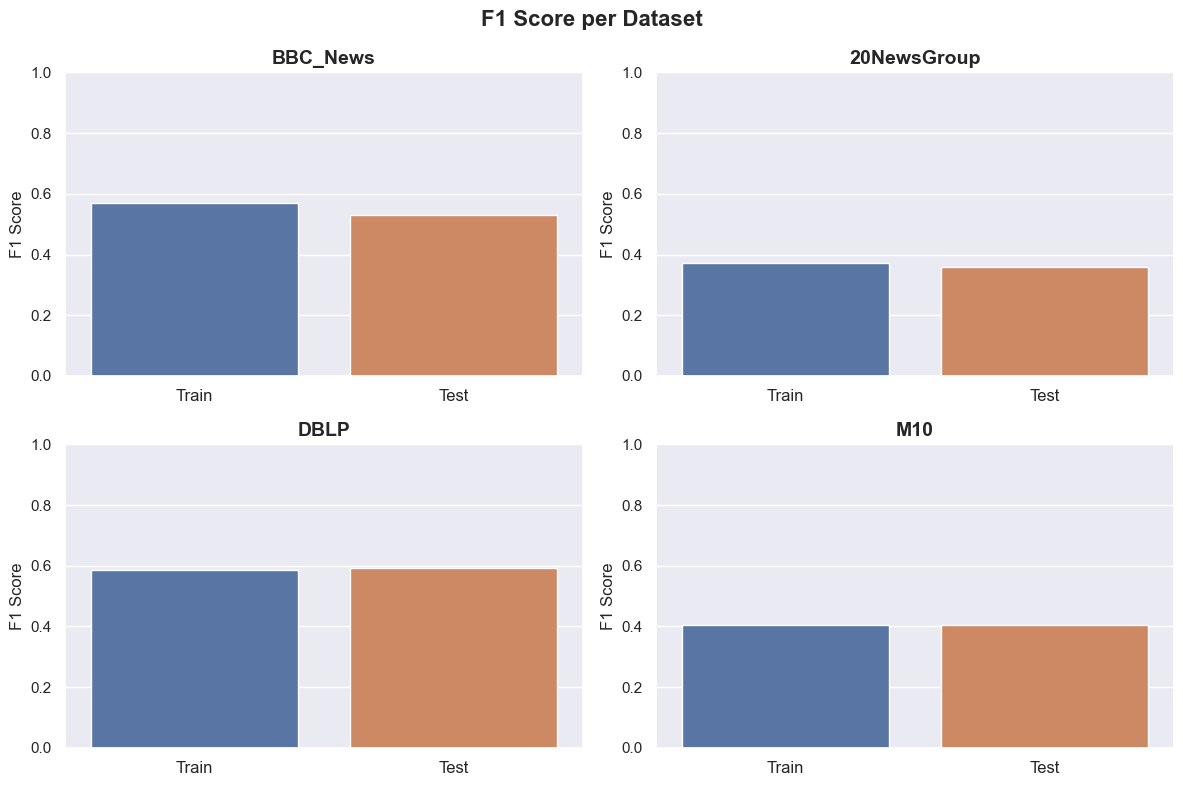

In [14]:
result_df = pd.read_csv('cache/performances.csv')

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

x, y = 0, 0

for dataset_name in result_df['dataset'].unique():
    dataset_df = result_df[result_df['dataset'] == dataset_name]

    sns.barplot(x='Dataset Type', y='F1 score', data=dataset_df, ax=ax[x, y])

    ax[x, y].set_title(dataset_name, fontsize=14, fontweight='bold')
    ax[x, y].set_xlabel('')
    ax[x, y].set_ylabel('F1 Score', fontsize=12)
    ax[x, y].set_xticklabels(['Train', 'Test'], fontsize=12)
    ax[x, y].set_ylim([0, 1])
    
    if y == 0:
        y += 1
    else:
        y = 0
        x += 1

fig.suptitle('F1 Score per Dataset', fontsize=16, fontweight='bold')

fig.tight_layout()
fig.savefig('../figures/lbl2transformervec_performances.png')